# Bank Account Fraudulent Application Detection(2)--Modeling

## 1.Data Preprocessing
- Data Cleaning: Clean the data to handle issues like missing values, duplicates, and outliers.
- Feature Engineering: Create new relevant features or transform existing ones to better capture patterns related to fraud.

In [41]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from summarytools import dfSummary

from sklearn.impute import KNNImputer
from sklearn.feature_selection import chi2, RFE
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,HistGradientBoostingClassifier, IsolationForest, HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split,StratifiedKFold,cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import randint, uniform
import optuna  # pip install optuna
from optuna.integration import LightGBMPruningCallback

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, f1_score, average_precision_score, recall_score,precision_score
from sklearn.metrics import auc, roc_curve, precision_recall_curve, roc_auc_score, log_loss
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay,ConfusionMatrixDisplay

import shap

In [2]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.5.3
numpy==1.24.1
seaborn==0.12.2
xgboost==1.7.6
optuna==3.5.0


In [3]:
df = pd.read_csv('./data/Base.csv')
df.shape

(1000000, 32)

### 1.1 Strategy I
1. Remove low variance column ('device_fraud_count' is constant), Remove "source".
2. Missing values: <50%: impute with median; >50%: impute with -1
3. Combine "phone_home_valid" and "phone_mobile_valid" to one new categorical column "phone_valid" (essentially the reverse of one-hot encoding)
4. LabelEncoding all the categorical columns

##### 1). Remove low variance column ('device_fraud_count' )

In [8]:
# Create a deep copy of the DataFrame
new_df = df.copy()
new_df = new_df.drop("device_fraud_count", axis=1)
new_df = new_df.drop("source", axis=1)
new_df.shape

(1000000, 30)

##### 2). Missing values imputation
<50% : impute with median.
>=50% : impute with -1.

In [5]:
#transfer missing values to nan
missingv_features1 = ['prev_address_months_count', 'current_address_months_count', 'bank_months_count',
       'session_length_in_minutes', 'device_distinct_emails_8w']
missingv_features2 =['intended_balcon_amount']
#convert missing value to NAN
for column in missingv_features1:
    new_df[column] = new_df[column].replace(-1, np.nan)

new_df[missingv_features2] = new_df[missingv_features2].mask(df[missingv_features2] < 0, np.nan)

In [6]:
missing_small = ['current_address_months_count', 'session_length_in_minutes',
 'device_distinct_emails_8w']
missing_medium = ['bank_months_count']
missing_large =['prev_address_months_count', 'intended_balcon_amount']

In [7]:
#<50% : impute with median
for i in (missing_small + missing_medium):
    new_df[i].fillna(new_df[i].median(), inplace=True)

In [ ]:
#>=50% : impute with -1
for i in (missing_small+missing_medium):
    new_df[i].fillna(-1, inplace=True)

##### 3). Combine "phone_home_valid" and "phone_mobile_valid" to one new categorical column "phone_valid" (essentially the reverse of one-hot encoding)

In [ ]:
df_temp = pd.DataFrame()
df_temp['phone_home_valid'] = new_df['phone_home_valid'].map({0: '0', 1: 'home'})
df_temp['phone_mobile_valid'] = new_df['phone_mobile_valid'].map({0: '0', 1: 'mobile'})

In [ ]:
new_df['phone_valid'] = df_temp['phone_home_valid'].astype(str) + df_temp['phone_mobile_valid'].astype(str)
new_df.drop(['phone_home_valid', 'phone_mobile_valid'], axis=1, inplace=True)
new_df.shape

(1000000, 29)

#### 4). Label Encoding all the categorical columns

In [ ]:
# Create a list of categorical features in the DataFrame new_df whose data type is `object`
cat_features = [x for x in new_df.columns if new_df[x].dtypes == "O"]
#label encoding categorical columns
label_encoder = LabelEncoder()
for i in cat_features:
    new_df[i] = label_encoder.fit_transform(new_df[i])

### 1.2 Strategy II one-hot encoding 'housing_status', 'device_os'
1. Remove low variance column ('device_fraud_count' is constant), Remove "source".
2. Missing values: <50%: impute with median; >50%: impute with -1
3. Combine "phone_home_valid" and "phone_mobile_valid" to one new categorical column "phone_valid" (essentially the reverse of one-hot encoding)
4. <b>one-hot encoding two most important features: 'housing_status', 'device_os', label encode the others.</b>

##### 1). Remove low variance column ('device_fraud_count' )

In [ ]:
# Create a deep copy of the DataFrame
new_df = df.copy()
new_df = new_df.drop("device_fraud_count", axis=1)
new_df = new_df.drop("source", axis=1)
new_df.shape

(1000000, 30)

##### 2). Missing values imputation
<50% : impute with median.
>=50% : impute with -1.

In [ ]:
#transfer missing values to nan
missingv_features1 = ['prev_address_months_count', 'current_address_months_count', 'bank_months_count',
       'session_length_in_minutes', 'device_distinct_emails_8w']
missingv_features2 =['intended_balcon_amount']
#convert missing value to NAN
for column in missingv_features1:
    new_df[column] = new_df[column].replace(-1, np.nan)

new_df[missingv_features2] = new_df[missingv_features2].mask(df[missingv_features2] < 0, np.nan)

In [ ]:
missing_small = ['current_address_months_count', 'session_length_in_minutes',
 'device_distinct_emails_8w']
missing_medium = ['bank_months_count']
missing_large =['prev_address_months_count', 'intended_balcon_amount']

In [ ]:
#<50% : impute with median
for i in (missing_small+missing_medium):
    new_df[i].fillna(new_df[i].median(), inplace=True)

In [ ]:
#>=50% : impute with -1
for i in (missing_small+missing_medium):
    new_df[i].fillna(-1, inplace=True)

##### 3). Combine "phone_home_valid" and "phone_mobile_valid" to one new categorical column "phone_valid" (essentially the reverse of one-hot encoding)

In [ ]:
df_temp = pd.DataFrame()
df_temp['phone_home_valid'] = new_df['phone_home_valid'].map({0: '0', 1: 'home'})
df_temp['phone_mobile_valid'] = new_df['phone_mobile_valid'].map({0: '0', 1: 'mobile'})

In [ ]:
new_df['phone_valid'] = df_temp['phone_home_valid'].astype(str) + df_temp['phone_mobile_valid'].astype(str)
new_df.drop(['phone_home_valid', 'phone_mobile_valid'], axis=1, inplace=True)
new_df.shape

(1000000, 29)

#### 4). One-Hot Encoding, Label Encoding the others

In [ ]:
# Create a list of categorical features in the DataFrame new_df whose data type is `object`
cat_features = [x for x in new_df.columns if new_df[x].dtypes == "O"]
cat1 = ['housing_status', 'device_os']
cat2 = [i for i in cat_features if i not in cat1 ]

In [ ]:
#label encoding cat1
label_encoder = LabelEncoder()
for i in cat2:
    new_df[i] = label_encoder.fit_transform(new_df3[i])
    
new_df.shape

(1000000, 30)

In [ ]:
# one-hot encoding 'housing_status', 'device_os'
new_df3 = pd.get_dummies(new_df, columns=cat1)
new_df3.shape

(1000000, 40)

In [ ]:
# new_df.to_csv('new_df.csv', index=False)  # Export to CSV without row indices")
# # run the code before here or load new_df saved last time
# new_df = pd.read_csv('./new_df.csv')

### 1.3 Strategy III
1. Remove low variance column ('device_fraud_count' is constant), Remove "source".
2. Missing values: <b><10%: impute with median; >50%: Transform to boolean column</b>
3. Combine "phone_home_valid" and "phone_mobile_valid" to one new categorical column "phone_valid" (essentially the reverse of one-hot encoding)
4. LabelEncoding all the categorical columns
5. <b>Build KNN model to impute missing values (10-50%)</b>

##### 1). Remove low variance column ('device_fraud_count' )

In [9]:
# Create a deep copy of the DataFrame
new_df = df.copy()
new_df = new_df.drop("device_fraud_count", axis=1)
new_df = new_df.drop("source", axis=1)
new_df.shape

(1000000, 30)

##### 2). Missing values imputation
<10% : impute with median.
>50% : transform to boolen columns.
10%-50%: plan to use KNNImputer in pipeline on X_train


In [10]:
#transfer missing values to nan
missingv_features1 = ['prev_address_months_count', 'current_address_months_count', 'bank_months_count',
       'session_length_in_minutes', 'device_distinct_emails_8w']
missingv_features2 =['intended_balcon_amount']
#convert missing value to NAN
for column in missingv_features1:
    new_df[column] = new_df[column].replace(-1, np.nan)

new_df[missingv_features2] = new_df[missingv_features2].mask(df[missingv_features2] < 0, np.nan)

In [11]:
missing_small = ['current_address_months_count', 'session_length_in_minutes',
 'device_distinct_emails_8w']
missing_medium = ['bank_months_count']
missing_large =['prev_address_months_count', 'intended_balcon_amount']

In [12]:
#<10% : impute with median
for i in (missing_small):
    new_df[i].fillna(new_df[i].median(), inplace=True)

In [13]:
#>=50%: Transform columns to boolean columns.
for i in (missing_large):
    # Convert numerical column to boolean
    boolean_column = new_df[i].fillna(0).astype(bool)
    # Replace non-zero values with True
    boolean_column = boolean_column.replace({True: 1, False: 0})
    # Add boolean column to DataFrame
    new_df[i] = boolean_column

In [14]:
new_df["has_prev_address"] = new_df["prev_address_months_count"] 
new_df["has_intended_balcon"] = new_df["intended_balcon_amount"]
new_df = new_df.drop("prev_address_months_count", axis=1)
new_df = new_df.drop("intended_balcon_amount", axis=1)

##### 3). Combine "phone_home_valid" and "phone_mobile_valid" to one new categorical column "phone_valid" (essentially the reverse of one-hot encoding)

In [15]:
df_temp = pd.DataFrame()
df_temp['phone_home_valid'] = new_df['phone_home_valid'].map({0: '0', 1: 'home'})
df_temp['phone_mobile_valid'] = new_df['phone_mobile_valid'].map({0: '0', 1: 'mobile'})

In [16]:
new_df['phone_valid'] = df_temp['phone_home_valid'].astype(str) + df_temp['phone_mobile_valid'].astype(str)
new_df.drop(['phone_home_valid', 'phone_mobile_valid'], axis=1, inplace=True)
new_df.shape

(1000000, 29)

In [ ]:
# new_df.to_csv('new_df.csv', index=False)  # Export to CSV without row indices")

In [ ]:
# # run the code before here or load new_df I saved last time
# new_df = pd.read_csv('./new_df.csv')

#### 4). Label Encoding all the categorical columns

In [17]:
# Create a list of categorical features in the DataFrame new_df whose data type is `object`
cat_features = [x for x in new_df.columns if new_df[x].dtypes == "O"]
#label encoding categorical columns
label_encoder = LabelEncoder()
for i in cat_features:
    new_df[i] = label_encoder.fit_transform(new_df[i])

#### 5). Build a KNNmodel to impute missing values in 'bank_months_count'

In [19]:
target = 'fraud_bool'
train_df = new_df[new_df['month'] < 6]

In [20]:
# Always use train_df to train KNN model to avoid data leaksge
target_m = 'bank_months_count'
features_m = list(train_df.columns)
features_m.remove(target_m)
features_m.remove(target)
print(len(features_m))

27


In [ ]:
# Split the dataset into two parts: with and without missing values
# df_missing_train = train_df[train_df[target_m].isna()]
df_not_missing_train = train_df[train_df[target_m].notna()]

# Separate features and target
X_train_m = df_not_missing_train[features_m]
y_train_m = df_not_missing_train[target_m]

# Initialize and train the KNN model
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train_m, y_train_m)

In [ ]:
# Predict missing values in new_df  (5min)
df_missing = new_df[new_df[target_m].isna()]
X_missing = df_missing[features_m]
y_missing_pred = knn.predict(X_missing)

# Save this array to a file
np.save('y_missing_KNNpred.npy', y_missing_pred)

In [18]:
# Run KNN model or Load the array from the file saved last time
y_missing_pred = np.load('y_missing_KNNpred.npy')

In [21]:
# impute missing value in 'bank_months_count' with KNN prediction
new_df.loc[new_df[target_m].isna(), target_m] = y_missing_pred

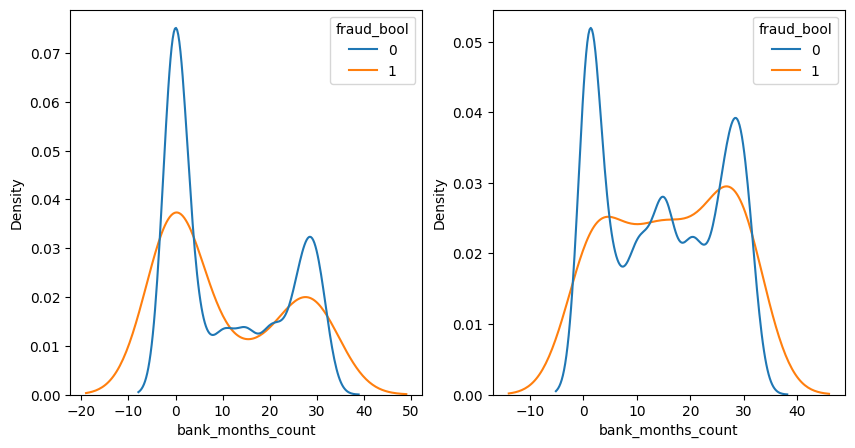

In [ ]:
#visualize the distribution of 'bank_months_count' with KDE plots before and after imputation 
fig, ax = plt.subplots(1, 2, figsize= (10,5))

# KDE plot, each KDE will be normalized independently.
sns.kdeplot(data=df, x='bank_months_count', hue = "fraud_bool", common_norm=False, ax = ax[0], bw_adjust=3 )
# KDE plot, each KDE will be normalized independently.
sns.kdeplot(data=new_df, x='bank_months_count', hue = "fraud_bool", common_norm=False, ax = ax[1], bw_adjust=3 )

# Show the plot
plt.show()

## 2.modeling
Do experiments using diverse models for different data processing strategies.<br>
The goal is to develop a model that can generalize patterns and relationships within the training data and perform well on new, unseen data. 

In [22]:
target = 'fraud_bool'
train_df = new_df[new_df['month'] < 6]
y_train = train_df[target]
X_train = train_df.drop(columns = [target, 'month'])

test_df = new_df[new_df['month'] >= 6]
y_test = test_df[target]
X_test = test_df.drop(columns = [target, 'month'])

In [26]:
# calculate base rate in training set
total_instances = len(train_df)
fraudulent_instances = train_df[target].sum()  # Assuming 1 represents fraud and 0 represents non-fraud
base_rate = (fraudulent_instances / total_instances) * 100
print(f"Base Rate: {base_rate:.2f}%")

Base Rate: 1.03%


### 2.1 Random Forest
For Tree-base models, there is no need to scale the input.
Use class_weight='balanced' for imbalanced data.  

In [110]:
steps = [
        # ('KNNimputer', KNNImputer(n_neighbors=2)),  #KNNImputer runs too long time(54min still runing)
        ('scaler', MinMaxScaler()), #Data Scaling
        ('rf', RandomForestClassifier(class_weight='balanced', random_state=42,n_jobs=-1,))] 
#n_jobs=-1: -1 means using all available processors to speed up for large datasets.
model_rf = Pipeline(steps)
model_rf = model_rf.fit(X_train, y_train)
#overfitting: AUC-ROC = 0.8, AUC-PR=0.1

<Axes: >

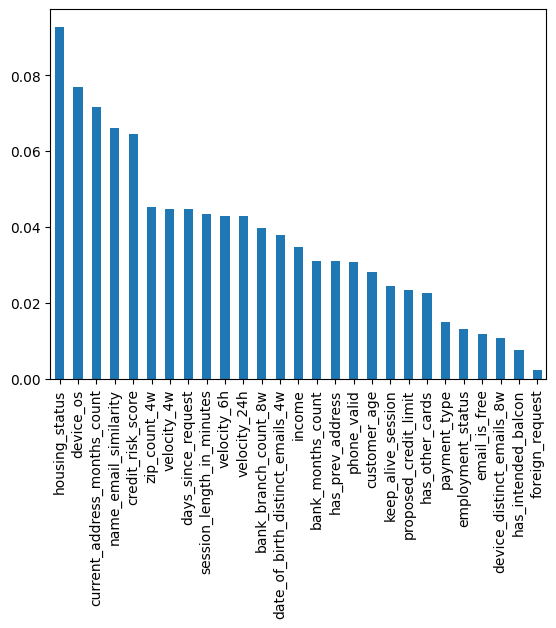

In [111]:
importances = pd.Series(model_rf.steps[1][1].feature_importances_, index = X_train.columns)
importances.sort_values(ascending = False , inplace = True)
importances.plot.bar()

RandomizedSearchCV <-- model_rf overfitting to major negative values 


In [118]:
pipe_rf = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
        ('classifier', RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'))]
)
# n_estimators =20, max_depth= 8,min_samples_split= , min_samples_leaf= ,
param = { 
          "classifier__n_estimators":randint(5,100),
          "classifier__max_depth":randint(0,100),
          "classifier__min_samples_split":randint(1,100),
          "classifier__min_samples_leaf":randint(1,100),
          # "classifier__ccp_alpha": uniform(0,1)  #->All Positive Model
        }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#StratifiedKFold as a cross-validation strategy, is particularly useful when dealing with imbalanced datasets. It ensures that each fold maintains the same distribution of target classes as the entire dataset.

# scorer = make_scorer(f1_score, greater_is_better = True)
# Create the scorer for AUC-PR
# scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)
# Define the AUC-ROC scoring function
scorer = make_scorer(roc_auc_score, greater_is_better=True)

#from sklearn.metrics import get_scorer_names
#get_scorer_names()
rf_cv1 = RandomizedSearchCV(pipe_rf, cv=cv, param_distributions=param, n_iter=1, scoring= scorer,random_state=42)
rf_cv1.fit(X_train,y_train)

print("Best parameter:", rf_cv1.best_params_)
print("Best CV score:", rf_cv1.cv_results_['mean_test_score'].max())

Best parameter: {'classifier__max_depth': 51, 'classifier__min_samples_leaf': 93, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 76}
Best CV score: 0.7521825858220362


In [119]:
# Get the best model
model_rf_cv = rf_cv1.best_estimator_
y_train_pred = model_rf_cv.predict(X_train)
y_test_pred = model_rf_cv.predict(X_test)
y_test_proba = model_rf_cv.predict_proba(X_test)

Best parameter: {'classifier__max_depth': 51, 'classifier__min_samples_leaf': 93, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 76}
Best CV score: 0.7521825858220362     0.88,0.16    6min

### 2.2 Gradient Boosting Trees
Cons:takes time to train and hard to tun hyperparameters(3 hours still running)
pros: generally better performance than rf.

In [125]:
steps = [('gbc', GradientBoostingClassifier(random_state=42))] 

# Calculate sample weights to handle class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model_gbc = Pipeline(steps)
model_gbc = model_gbc.fit(X_train, y_train, gbc__sample_weight=sample_weights)
#12min  0.89,0.18

<Axes: >

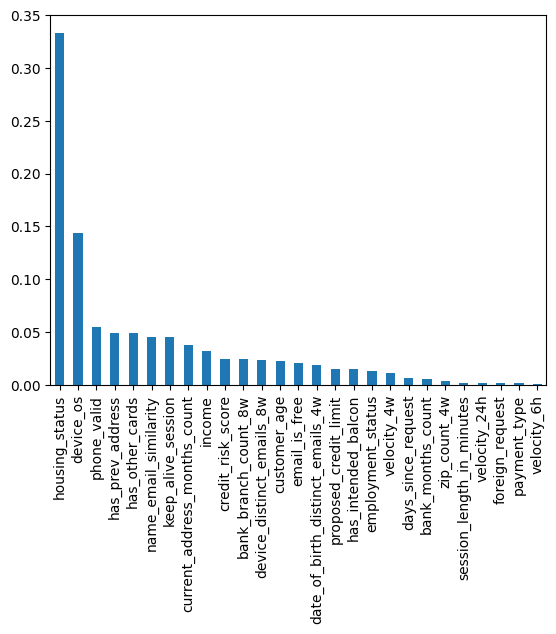

In [126]:
importances = pd.Series(model_gbc.steps[0][1].feature_importances_, index = X_train.columns)
importances.sort_values(ascending = False , inplace = True)
importances.plot.bar()

In [127]:
y_train_pred = model_gbc.predict(X_train)
y_test_pred = model_gbc.predict(X_test)
y_test_proba = model_gbc.predict_proba(X_test)

It's hard to tune hyperparameters as it takes long time to run.

### 2.3 XGboost

In [35]:
# Calculate the scale_pos_weight to handle class imbalance
# The formula is: scale_pos_weight = count(negative examples) / count(positive examples)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

steps = [
        ('scaler', MinMaxScaler()),
        ('xgb', XGBClassifier(max_depth=2, scale_pos_weight=scale_pos_weight, random_state=42,n_jobs=-1,))] 
#n_jobs=-1: -1 means using all available processors to speed up for large datasets.
model_xgb = Pipeline(steps)
model_xgb = model_xgb.fit(X_train, y_train)
#49s, 0.89,0.19      -->scaler: 59s, 


<Axes: >

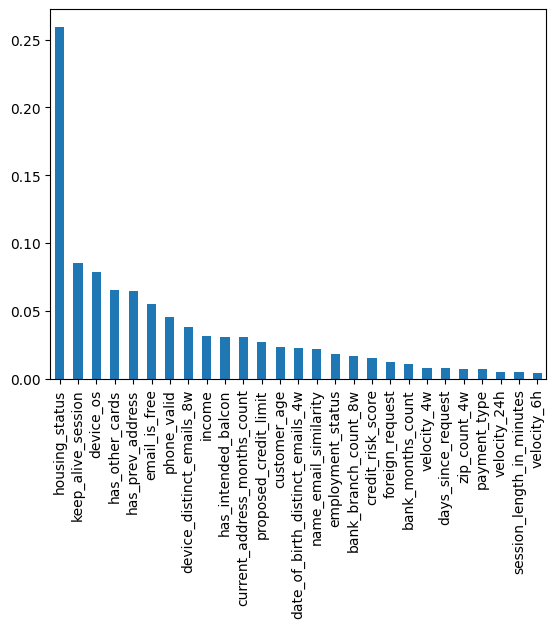

In [144]:
importances = pd.Series(model_xgb.steps[1][1].feature_importances_, index = X_train.columns)
importances.sort_values(ascending = False , inplace = True)
importances.plot.bar()

XG-RandomizedSearchCV 

In [166]:
# Calculate the scale_pos_weight to handle class imbalance. The formula is: scale_pos_weight = count(negative examples) / count(positive examples)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

pipe_xgb = Pipeline(
    steps=[
          ('scaler', MinMaxScaler()),
          ('classifier', XGBClassifier(max_depth= 3, scale_pos_weight=scale_pos_weight, random_state=42,n_jobs=-1))]
)
# n_estimators =20, max_depth= 8,min_samples_split= , min_samples_leaf= ,
param = { 
          # "classifier__gamma":uniform(0, 0.3),
          # "classifier__n_estimators":randint(5,100),
          # "classifier__max_depth":randint(2,10),
          # "classifier__min_samples_split":randint(1,100),
          # "classifier__min_samples_leaf":randint(1,100),
          # "classifier__ccp_alpha": uniform(0,1)  #->All Positive Model
        }
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#StratifiedKFold as a cross-validation strategy, is particularly useful when dealing with imbalanced datasets. It ensures that each fold maintains the same distribution of target classes as the entire dataset.

# scorer = make_scorer(f1_score, greater_is_better = True)
# Create the scorer for AUC-PR
scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

#from sklearn.metrics import get_scorer_names
#get_scorer_names()
xgb_cv1 = RandomizedSearchCV(pipe_xgb, cv=2, param_distributions=param, n_iter=1, scoring= scorer,random_state=42)
xgb_cv1.fit(X_train,y_train)

print("Best parameter:", xgb_cv1.best_params_)
print("Best CV score:", xgb_cv1.cv_results_['mean_test_score'].max())

Best parameter: {}
Best CV score: 0.12395989932106888


Best parameter: {'classifier__max_depth': 8}
Best CV score: 0.07412404222958141           ,5min, 0.82,0.11

max_depth = 3: Best parameter: {} Best CV score: 0.12395989932106888,  1min,0.89,0.19


### 2.4 HistGradientBoostingClassifier

In [24]:
steps = [
        # ('KNNimputer', KNNImputer(n_neighbors=2)),  #KNNImputer runs too long time(54min still runing)
        ('scaler', MinMaxScaler()),
        # ("smote",SMOTE(random_state=42)),
        ('hgbc', HistGradientBoostingClassifier(class_weight='balanced',random_state=42))
        ] 
model_hgbc = Pipeline(steps)
model_hgbc = model_hgbc.fit(X_train, y_train)
#13s, train_recall0.84,0.85,   0.89,0.19
#SMOTE train_recall1,0.11,     0.88,0.15

------classification_report of train data:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    786838
           1       0.05      0.85      0.10      8151

    accuracy                           0.84    794989
   macro avg       0.52      0.85      0.50    794989
weighted avg       0.99      0.84      0.90    794989


------classification_report of test data:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    202133
           1       0.06      0.80      0.11      2878

    accuracy                           0.82    205011
   macro avg       0.53      0.81      0.51    205011
weighted avg       0.98      0.82      0.89    205011



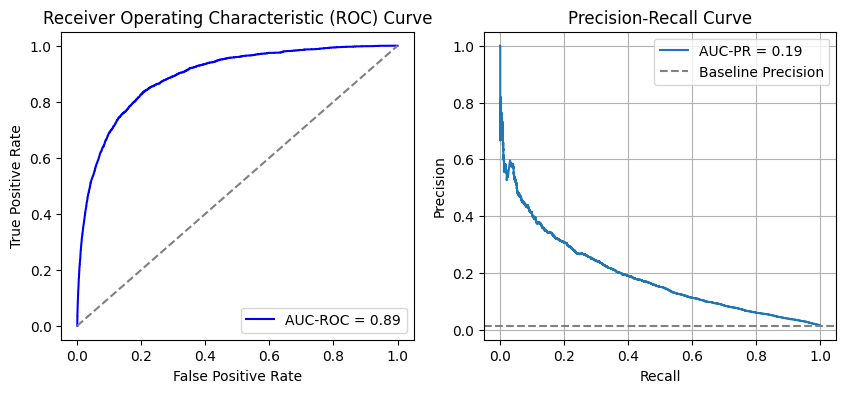

In [31]:
#HistGradientBoosting model evaluation
model_evaluation(model_hgbc)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.13      0.54      0.21      2878

    accuracy                           0.94    205011
   macro avg       0.56      0.74      0.59    205011
weighted avg       0.98      0.94      0.96    205011

Selected_threshold: 0.7928
Recall@ 13% FPR : 0.5375


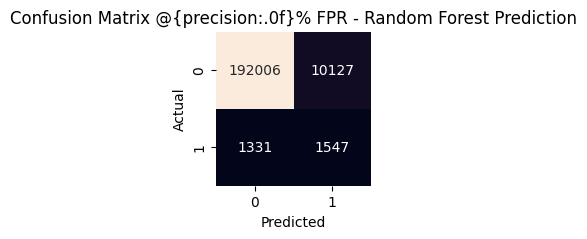

In [39]:
threshold_finder(model_hgbc)

### 2.5 LGBMClassifier
LightGBM (Light Gradient Boosting Machine) is a gradient boosting framework developed by Microsoft that is designed for distributed and efficient training of large-scale machine learning models. <br>
LightGBM uses a leaf-wise tree growth strategy, which grows the tree leaf-wise (best-first) rather than level-wise (depth-first) like XGBoost and Random Forest. This can lead to faster training times but may be more prone to overfitting on small datasets.<br> LightGBM has built-in support for handling categorical features, whereas XGBoost and Random Forest typically require one-hot encoding or label encoding of categorical features.<br>

In [38]:
param_grid = {
        "n_estimators": 1000,
		"learning_rate": 0.27876558106913024,
		"num_leaves": 540,
		"max_depth": 5,
		"min_data_in_leaf": 2400,
		"lambda_l1": 55,
		"lambda_l2": 25,
		"min_gain_to_split": 0.1768548525618302,
		"bagging_fraction": 0.2,
		"bagging_freq": 1,
		"feature_fraction": 0.5,
}

In [24]:
steps = [
        ('scaler', MinMaxScaler()),
        # ("smote",SMOTE(random_state=42)),
        ('lgbm', LGBMClassifier(class_weight='balanced', random_state=42,n_jobs=-1, 
                                # **param_grid
                                ))] 
model_lgbm = Pipeline(steps)
model_lgbm = model_lgbm.fit(X_train, y_train)
#6.4s: AUC-ROC = 0.89, AUC-PR=0.19   Train_recall:0.83,0.83, Feature Importance is totally different from xgb,gbc,rf
#SMOTE:  AUC-ROC = 0.87, AUC-PR=0.15    Train_recall:1,0.08

[LightGBM] [Info] Number of positive: 8151, number of negative: 786838
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2723
[LightGBM] [Info] Number of data points in the train set: 794989, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


<Axes: >

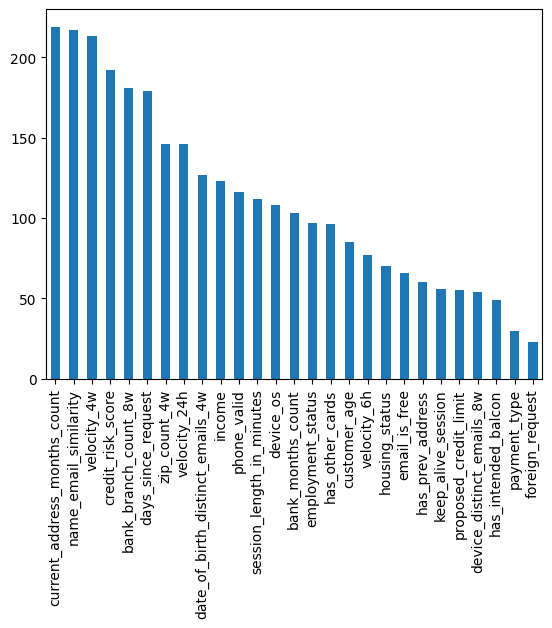

In [26]:
importances = pd.Series(model_lgbm.steps[1][1].feature_importances_, index = X_train.columns)
importances.sort_values(ascending = False , inplace = True)
importances.plot.bar()

------classification_report of train data:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    786838
           1       0.05      0.86      0.10      8151

    accuracy                           0.83    794989
   macro avg       0.52      0.85      0.50    794989
weighted avg       0.99      0.83      0.90    794989


------classification_report of test data:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    202133
           1       0.06      0.81      0.11      2878

    accuracy                           0.82    205011
   macro avg       0.53      0.81      0.50    205011
weighted avg       0.98      0.82      0.89    205011



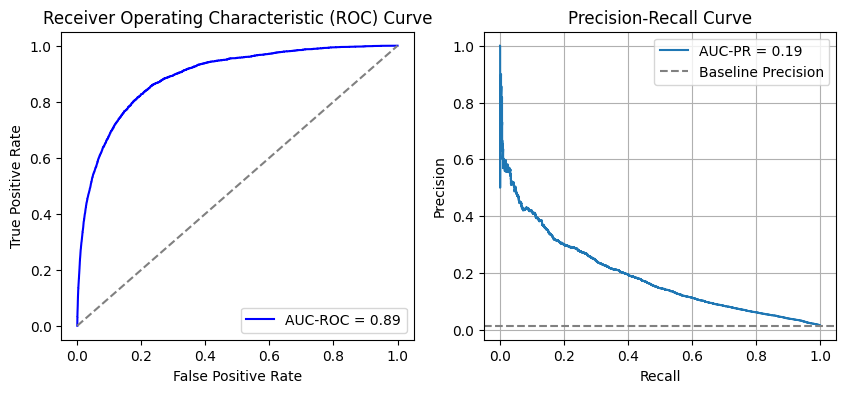

In [30]:
model_evaluation(model_lgbm)

#### Hyperparameters tuning via optuna

In [43]:

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1),
    }

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    cv_scores = np.empty(4)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LGBMClassifier(class_weight='balanced', objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            # early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
#create the study and run a few trials
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=10)

In [45]:
#call best_value and bast_params attributes
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.34557
	Best params:
		n_estimators: 1000
		learning_rate: 0.1461907503846088
		num_leaves: 2480
		max_depth: 4
		min_data_in_leaf: 7500
		lambda_l1: 50
		lambda_l2: 5
		min_gain_to_split: 3.7164681158346573
		bagging_fraction: 0.4
		bagging_freq: 1
		feature_fraction: 0.30000000000000004


n_estimators: 1000
		learning_rate: 0.23802285027988235
		num_leaves: 1760
		max_depth: 6
		min_data_in_leaf: 5100
		lambda_l1: 30
		lambda_l2: 55
		min_gain_to_split: 1.8570739082757197
		bagging_fraction: 0.6000000000000001
		bagging_freq: 1
		feature_fraction: 0.7

		Best value (rmse): 0.04324

Best params:      ROC0.89, PR0.14
		n_estimators: 1000
		learning_rate: 0.27876558106913024
		num_leaves: 540
		max_depth: 5
		min_data_in_leaf: 2400
		lambda_l1: 55
		lambda_l2: 25
		min_gain_to_split: 0.1768548525618302
		bagging_fraction: 0.2
		bagging_freq: 1
		feature_fraction: 0.5

#### LGBM-RandomizedSearchCV 

In [ ]:
pipe_lgbm = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
        # ("oversampler", RandomOverSampler(random_state=42)),
        # ("smote",SMOTE(random_state=42)),  #class_weight='balanced', 
        ('classifier', LGBMClassifier(n_estimators =720, learning_rate=0.01, num_leaves=1658,max_depth=9,class_weight='balanced', random_state=42,n_jobs=-1))]
)
# Default: n_estimators =100, learning_rate=0.1, max_bin=255
#num_leaves=31,max_depth=-1,min_data_in_leaf=20
#lambda_l1= 0, lambda_l2 = 0,min_gain_to_split=0,bagging_fraction=1,feature_fraction=1
#early_stopping_round=0
param = { 
        #   "classifier__max_depth":randint(2,12),
        #  'classifier__num_leaves':randint(20,3000),
        # #  'classifier__min_data_in_leaf':
        #  "classifier__n_estimators":randint(20,1000),
        #  'classifier__learning_rate': uniform(0,0.3),
        #  'classifier__min_data_in_leaf': randint(10,200),
         'classifier__lambda_l1' : uniform(0,100), 
         'classifier__lambda_l2' : uniform(0,100),
        #  'classifier__min_gain_to_split' : randint(0,15),
        #  'classifier__bagging_fraction':uniform(0,1),  
        #  'classifier__feature_fraction':uniform(0,1)
        }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#StratifiedKFold as a cross-validation strategy, is particularly useful when dealing with imbalanced datasets. It ensures that each fold maintains the same distribution of target classes as the entire dataset.

#from sklearn.metrics import get_scorer_names
#get_scorer_names()
# scorer = make_scorer(f1_score, greater_is_better = True)
# Create the scorer for AUC-PR
scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

lgbm_cv1 = RandomizedSearchCV(pipe_lgbm, cv=cv, param_distributions=param, n_iter=1, scoring= scorer,random_state=42)
lgbm_cv1.fit(X_train,y_train)

print("Best parameter:", lgbm_cv1.best_params_)
print("Best CV score:", lgbm_cv1.cv_results_['mean_test_score'].max())

Best parameter: {'classifier__n_estimators': 56}
Best CV score: 0.15044047770819863    , 0.89,0.18

Best parameter: {'classifier__feature_fraction': 0.3745401188473625, 'classifier__lambda_l2': 10.50714306409916, 'classifier__learning_rate': 0.7319939418114051, 'classifier__max_depth': 6, 'classifier__min_data_in_leaf': 30, 'classifier__n_estimators': 87, 'classifier__num_leaves': 84}
Best CV score: 0.11115948400048711                     ,0.86,0.14

Best parameter: {'classifier__max_depth': 8}
Best CV score: 0.15757101496140416   , 0.89,0.19

    class_weight='balanced'
Best parameter: {'classifier__learning_rate': 0.11236203565420874, 'classifier__max_depth': 9, 'classifier__n_estimators': 720, 'classifier__num_leaves': 1658}
Best CV score: 0.07752908027978193    ,5min, 0.78,0.08. Good0 part,fraud part overfitting
    Oversampling
Best parameter: {'classifier__learning_rate': 0.11236203565420874, 'classifier__max_depth': 9, 'classifier__n_estimators': 720, 'classifier__num_leaves': 1658}
Best CV score: 0.06878923940906567    10min
    scale_pos_weight=96.6,  300                 
Best parameter: {'classifier__learning_rate': 0.11236203565420874, 'classifier__max_depth': 9, 'classifier__n_estimators': 720, 'classifier__num_leaves': 1658}
Best CV score: 0.06921500610139082    5min, 0.77,0.08
    SMOTE
Best parameter: {'classifier__learning_rate': 0.11236203565420874, 'classifier__max_depth': 9, 'classifier__n_estimators': 720, 'classifier__num_leaves': 1658}
Best CV score: 0.1122005924779054       ,10min, 0.85,0.12. Good0 part,fraud part still a little overfitting



Best parameter: {'classifier__bagging_fraction': 0.3745401188473625, 'classifier__feature_fraction': 0.9507143064099162, 'classifier__lambda_l1': 73.1993941811405, 'classifier__lambda_l2': 59.86584841970366, 'classifier__learning_rate': 0.04680559213273095, 'classifier__max_depth': 4, 'classifier__min_data_in_leaf': 84, 'classifier__min_gain_to_split': 10, 'classifier__n_estimators': 107, 'classifier__num_leaves': 2939}
Best CV score: 0.14029168526085098      29s, 0.89,0.17    train_recall: 0.82,0.82

SMOTE  Best parameter: {'classifier__bagging_fraction': 0.3745401188473625, 'classifier__feature_fraction': 0.9507143064099162, 'classifier__lambda_l1': 73.1993941811405, 'classifier__lambda_l2': 59.86584841970366, 'classifier__learning_rate': 0.04680559213273095, 'classifier__max_depth': 4, 'classifier__min_data_in_leaf': 84, 'classifier__min_gain_to_split': 10, 'classifier__n_estimators': 107, 'classifier__num_leaves': 2939}
Best CV score: 0.10181474759932543         ,0.87,0.14           train_recall: 0.95,0.46

set  n_estimators =720, learning_rate=0.11, num_leaves=1658,max_depth=9:
Best parameter: {'classifier__bagging_fraction': 0.3745401188473625, 'classifier__feature_fraction': 0.9507143064099162, 'classifier__lambda_l1': 73.1993941811405, 'classifier__lambda_l2': 59.86584841970366, 'classifier__min_gain_to_split': 6}
Best CV score: 0.15462381124421182     train_recall: 0.89,0.97.   0.89,0.18

Best parameter: {'classifier__lambda_l1': 37.454011884736246, 'classifier__lambda_l2': 95.07143064099162}
Best CV score: 0.14313528086697197     train_recall: 0.97,1.      0.88,0.16
    SMOTE
Best parameter: {'classifier__lambda_l1': 37.454011884736246, 'classifier__lambda_l2': 95.07143064099162}
Best CV score: 0.14063663019193884    train_recall:1,0.07,     0.89,0.17

Best parameter: {'classifier__lambda_l1': 37.454011884736246}
Best CV score: 0.13778527676013236     train_recall: 0.98,1.      0.88,0.16

set  n_estimators =720, learning_rate=0.1, num_leaves=1658,max_depth=9:
SMOTE:  Best parameter: {'classifier__lambda_l1': 37.454011884736246, 'classifier__lambda_l2': 95.07143064099162}
Best CV score: 0.11540927880759659   ,9min, train_recall: 0.99,0.21.      0.88,0.16, 
Best parameter: {'classifier__lambda_l1': 37.454011884736246, 'classifier__lambda_l2': 95.07143064099162}
Best CV score: 0.15027139137729914     train_recall:0.87,0.93,   0.89,0.18

In [ ]:
# # Get the best model
# model_lgbm_cv = lgbm_cv1.best_estimator_
# y_train_pred = model_lgbm_cv.predict(X_train)
# y_test_pred = model_lgbm_cv.predict(X_test)
# y_test_proba = model_lgbm_cv.predict_proba(X_test)

### 2.6 Isolation Forest 

In [99]:
steps = [
    ('isof', IsolationForest(contamination=0.01, random_state=42)
    )] 
model_isof = Pipeline(steps)
model_isof = model_isof.fit(X_train)

c:\Users\tliu1\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [101]:
# Predict outliers on the test data
y_trian_pred = model_isof.predict(X_train)

# # Convert predictions to binary (1 for inliers, -1 for outliers)
# y_train_pred_binary = np.where(y_trian_pred == 1, 1, -1)
#reshape the prediction values to 0 for legid, 1 for fraud
y_train_pred[y_train_pred ==1] = 0
y_train_pred[y_train_pred ==-1] = 1

# Evaluate the model
print("Classification Report:\n", classification_report(y_train, y_train_pred))

Accuracy: 0.9897470279462987


c:\Users\tliu1\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tliu1\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    786838
           1       0.00      0.00      0.00      8151

    accuracy                           0.99    794989
   macro avg       0.49      0.50      0.50    794989
weighted avg       0.98      0.99      0.98    794989



c:\Users\tliu1\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


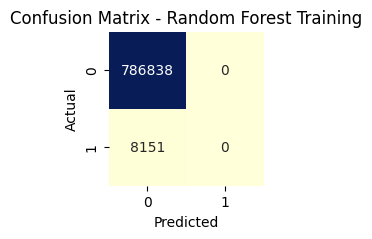

In [102]:
# Compute the confusion matrix
confusion_mat = confusion_matrix(y_train, y_train_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(2,2))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Isolation Forest Training')
plt.show()

In [103]:
# Predict outliers on the test data
y_test_pred = model_isof.predict(X_test)

# # Convert predictions to binary (1 for inliers, -1 for outliers)
# y_pred_binary = np.where(y_pred == 1, 1, -1)
#reshape the prediction values to 0 for legid, 1 for fraud
y_test_pred[y_test_pred ==1] = 0
y_test_pred[y_test_pred ==-1] = 1

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy: 0.9759915321616889
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    202133
           1       0.02      0.02      0.02      2878

    accuracy                           0.98    205011
   macro avg       0.51      0.50      0.50    205011
weighted avg       0.97      0.98      0.97    205011



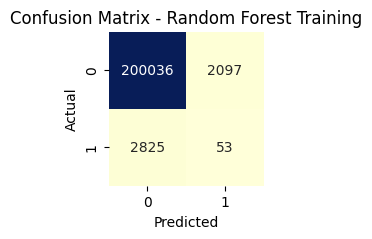

In [104]:
# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test, y_test_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(2,2))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Isolation Forest Testing')
plt.show()

## 3.Model Evaluation

In [28]:
def model_evaluation(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    # A founction to evaluate model
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    #print classification_reports (labels=[0, 1])
    print("------classification_report of train data:")
    print(classification_report(y_train, y_train_pred))
    print("\n------classification_report of test data:")
    print(classification_report(y_test, y_test_pred))
    
    ## AUC-ROC curve and AUC-PR curve
    # Calculate the ROC curve points and AUC-ROC
    fpr, tpr, thresholds1 = roc_curve(y_test, y_test_proba[:, 1])
    auc_roc = roc_auc_score(y_test, y_test_proba[:, 1])

    # Calculate precision-recall curve points and AUC-PR
    precision, recall, thresholds1 = precision_recall_curve(y_test, y_test_proba[:, 1])
    auc_pr = auc(recall, precision)

    #plot the ROC curve and PR curve
    # Create a grid of subplots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    # Plot the ROC curve
    ax[0].plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc_roc:.2f}')
    ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier AUC=0.5 line
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    ax[0].legend()
    # Plot precision-recall curve
    ax[1].plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    ax[1].axhline(y=y_test.mean(), color='gray', linestyle='--', label='Baseline Precision')
    ax[1].legend()
    ax[1].grid(True)
    # Show plot
    plt.show()

In [38]:
def threshold_finder(best_model, X_test=X_test, y_test=y_test):
    # A function to find the threshold where FPR is closest to 0.05
    #Predictions
    y_test_proba = best_model.predict_proba(X_test)
    # Calculate thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:, 1])

    # Find the threshold where FPR is closest to 0.05
    closest_to_005_index = np.argmin(np.abs(fpr - 0.05))
    selected_threshold = thresholds[closest_to_005_index]
    # # get the best threshold
    # J = tpr - fpr
    # ix = np.argmax(J)
    # selected_threshold = thresholds[ix]
    y_test_pred1 = (y_test_proba[:,1] >= selected_threshold).astype(int) 
    
    # print Classification Report at selected threshold
    print(classification_report(y_test, y_test_pred1))
    print(f'Selected_threshold: {selected_threshold:.2f}')
    recall = recall_score(y_test, y_test_pred1)
    precision = 100* precision_score(y_test, y_test_pred1)
    print(f'Recall@ {precision:.0f}% FPR : {recall:.2f}')

    # Compute the confusion matrix
    confusion_mat = confusion_matrix(y_test, y_test_pred1)

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(2,2))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix @ {precision:.0f}% FPR - Model Prediction')
    plt.show()

### Best Model and Evaluation

Model comparation

In [ ]:
#plot different models with ROC and PR scores

Best Model Evaluation

------classification_report of train data:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    786838
           1       0.05      0.82      0.09      8151

    accuracy                           0.82    794989
   macro avg       0.52      0.82      0.49    794989
weighted avg       0.99      0.82      0.89    794989


------classification_report of test data:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    202133
           1       0.06      0.82      0.11      2878

    accuracy                           0.80    205011
   macro avg       0.53      0.81      0.50    205011
weighted avg       0.98      0.80      0.88    205011



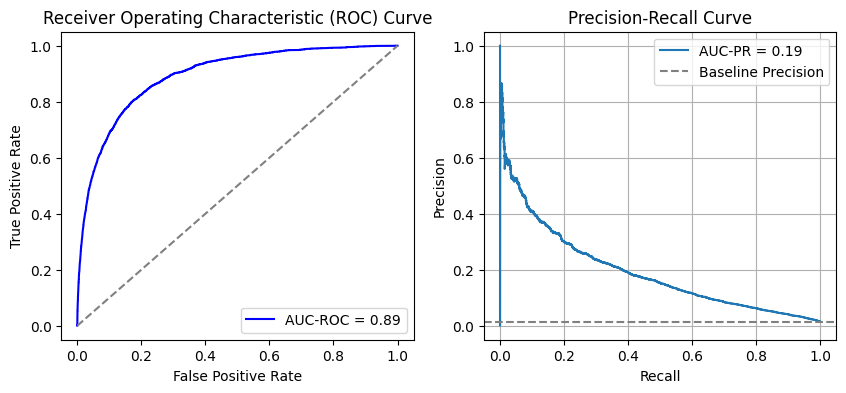

In [39]:
best_model = model_xgb
model_evaluation(best_model)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    202133
           1       0.13      0.55      0.22      2878

    accuracy                           0.94    205011
   macro avg       0.56      0.75      0.59    205011
weighted avg       0.98      0.94      0.96    205011

Selected_threshold: 0.80
Recall@ 13% FPR : 0.55


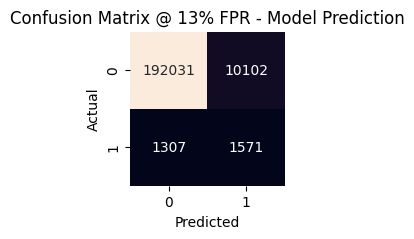

In [40]:
threshold_finder(best_model)

## 4.Interpretation and Conclusions:
Interpret the results of analysis. Provide clear explanations of key findings and their implications. Draw conclusions based on the evidence from your data. Understand the importance of different features in making predictions.

Permutation explainer: 10002it [12:32:21,  4.56s/it]                                 
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


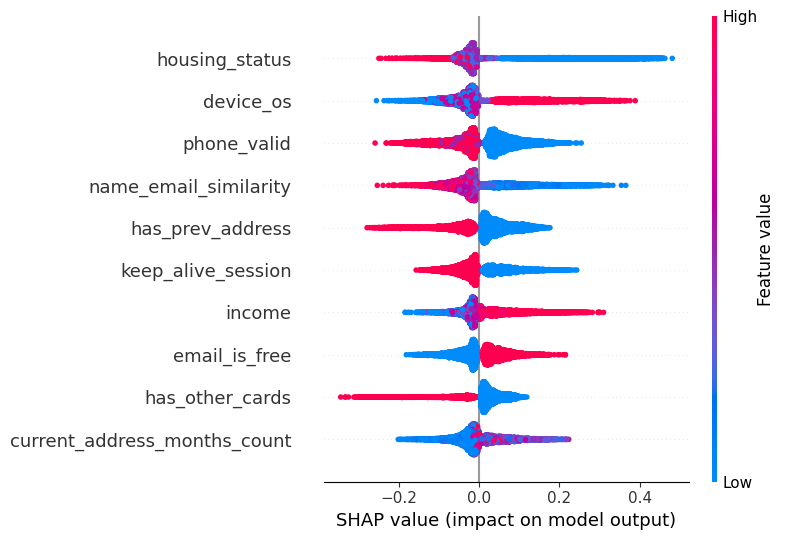

In [44]:
# Explain model predictions
explainer = shap.Explainer(best_model.predict, X_train)
shap_values = explainer(X_test.loc[:10000, :])

# Visualize the explanations
shap.summary_plot(shap_values, X_test.loc[:10000, :], feature_names=X_test.columns, max_display=10)

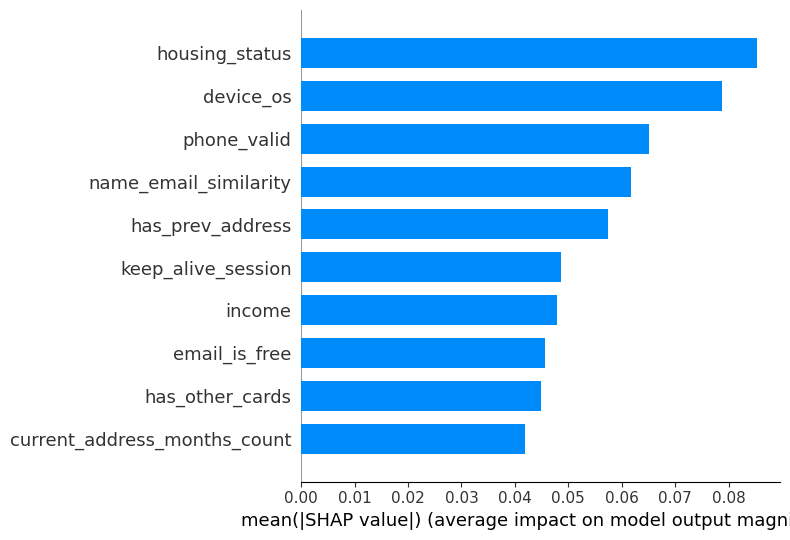

In [48]:
shap.summary_plot(shap_values, X_test.loc[:10000, :], plot_type="bar", feature_names=X_test.columns, max_display=10)

Permutation explainer: 10002it [24:19,  6.79it/s]                           
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


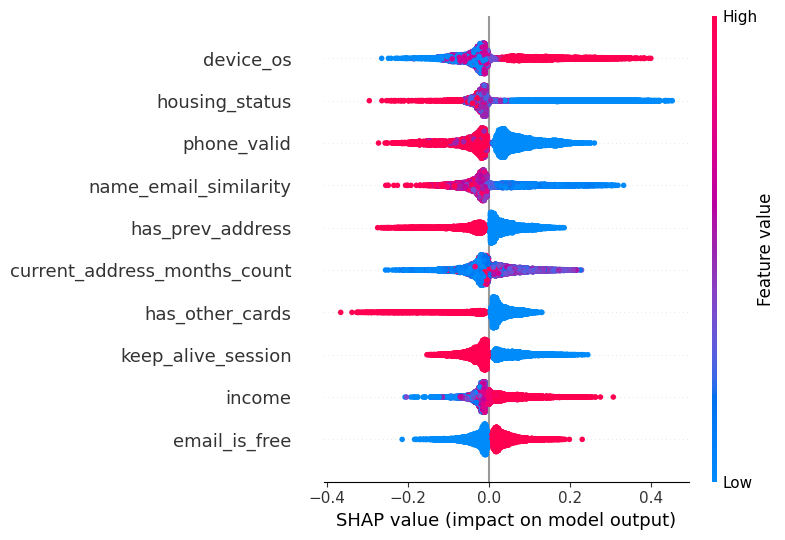

In [43]:
# Initialize SHAP explainer    (run 24min)
explainer = shap.Explainer(model_lgbm.predict, X_train)
shap_values = explainer(X_test.loc[:10000, :])

# Summary plot
shap.summary_plot(shap_values, X_test.loc[:10000, :], feature_names=X_test.columns, max_display=10)

Positive SHAP values indicate features that push the prediction higher, while negative values push the prediction lower.

## 5.Future work

1. EDA on Outliers to get further insights. 
2. As the data is temporal, think about Time series
3. Deep learning
4. Deploy: 
If the model performs well and meets the desired criteria, consider deploying it in a real-world setting for making predictions on new data.